In [130]:
import pandas as pd
import pickle
import numpy as np
import seaborn as sns
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.preprocessing import MinMaxScaler

# dataset is accessible at https://s3.amazonaws.com/amazon-reviews-pds/tsv/index.txt (https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Books_v1_02.tsv.gz)
df = pd.read_csv('amazon_reviews_us_Digital_Software_v1_00.tsv', sep='\t', dtype={'star_rating': float})

df.columns = ['marketplace', 'customer_id', 'review_id', 'product_id', 'product_parent', 'product_title', 'product_category', 'star_rating',
              'helpful_votes', 'total_votes', 'vine', 'verified_purchase', 'review_headline', 'review_body', 'review_date']

df.drop(['marketplace', 'product_parent', 'product_title', 'product_category', 'helpful_votes', 'total_votes', 'vine', 'verified_purchase',
         'review_headline'],
        axis='columns', inplace=True)

Number of customers: 308
Number of products: 109
(1063, 6)


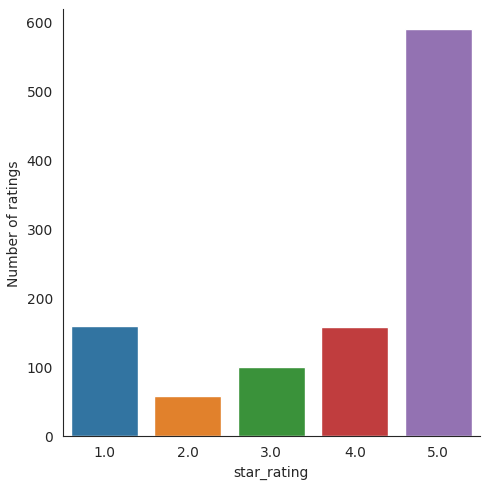

In [144]:
# Data analysis

# Ratings distribution
with sns.axes_style('white'):
    g = sns.catplot(data=df, aspect=1.0, x="star_rating", kind='count')
    g.set_ylabels("Number of ratings")

# Numbers in data
print("Number of customers: " + str(len(np.unique(df.customer_id))))
print("Number of products: " + str(len(np.unique(df.product_id))))

no_of_rated_products_per_user = df.groupby(by='customer_id')['star_rating'].count().sort_values(ascending=False)

no_of_rated_products_per_user.head()

print(df.shape)

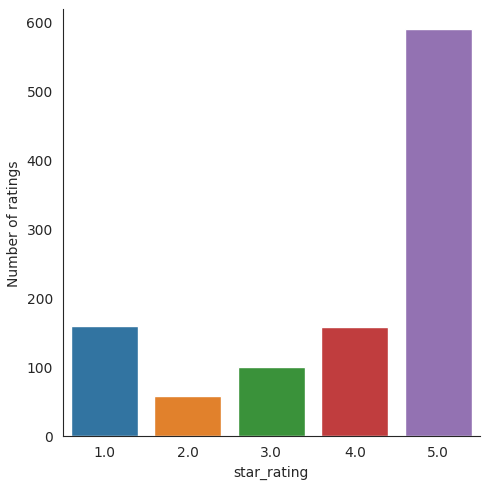

In [132]:
# Using just a subset of the data (the one with more common id in order for there to be more correlation)

customer_count = df['customer_id'].value_counts()
customers_with_multiple_reviews = customer_count[customer_count > 3].index
df = df[df['customer_id'].isin(customers_with_multiple_reviews)]

product_count = df['product_id'].value_counts()
products_with_multiple_reviews = product_count[product_count > 3].index
df = df[df['product_id'].isin(products_with_multiple_reviews)]

# Distribution is similar
with sns.axes_style('white'):
    g = sns.catplot(data=df, aspect=1.0, x="star_rating", kind='count')
    g.set_ylabels("Number of ratings")

In [133]:
def apply_pivot(df, fillby=None):
    pivot_table = df.pivot_table(index='customer_id', columns='product_id', values='star_rating')
    if fillby is not None:
        pivot_table = pivot_table.fillna(fillby)
    return pivot_table

# Train-test split (training on older data to predict more recent data)
df = df.sort_values(by='review_date')

split_index = int(0.7 * len(df))

train = df[:split_index]
test = df[split_index:]

test = test[test.customer_id.isin(train.customer_id)] # to guarantee known customer ids in test
test = test[test.product_id.isin(train.product_id)] # to guarantee known product ids in test

df_train_pivot = apply_pivot(df = train, fillby = 0)
df_test_pivot = apply_pivot(df = test, fillby = 0)

In [134]:
# Creating dummies to help to know wether a product has been rated or not
# Train
dummy_train = train.copy()

# Exclude products already rated by the user
# Obtain a table with 0 when products have been rated and 1 when they haven't
dummy_train['star_rating'] = dummy_train['star_rating'].apply(lambda x: 0 if x >= 1 else 1) 
dummy_train = apply_pivot(df = dummy_train, fillby = 1)

# Exclude products not rated by the user
# Obtain a table with 1 when products have been rated and 0 when they haven't
dummy_test = test.copy()
dummy_test['star_rating'] = dummy_test['star_rating'].apply(lambda x: 1 if x >= 1 else 0)
dummy_test = apply_pivot(df = dummy_test, fillby = 0)

In [135]:
# Calculate mean and subtract it from ratings for ajusted cosine similarity
train_pivot = apply_pivot(df=train)
mean = train_pivot.mean(axis=1, skipna=True)

df_train_subtracted = train_pivot.sub(mean, axis=0)

# Set ratings to 0 where a user hasn't given any rating
df_train_subtracted.fillna(0, inplace=True)

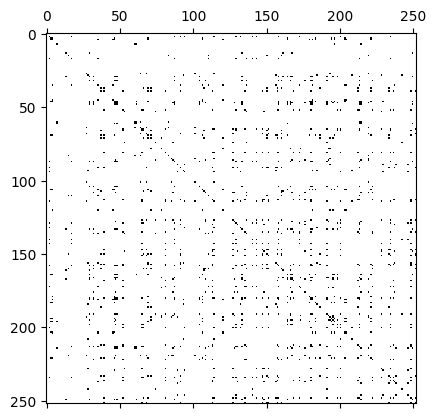

In [136]:
# Create the User Similarity Matrix
user_correlation = 1 - pairwise_distances(df_train_subtracted, metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0

import matplotlib.pylab as plt

plt.spy(user_correlation)

user_correlation_df = pd.DataFrame(user_correlation, index=df_train_subtracted.index, columns=df_train_subtracted.index)

In [137]:
# Rating predicted by the user is weighted sum of correlation with the product rating 
user_predicted_ratings = np.dot(user_correlation, df_train_pivot)

# Products not rated by user 
user_final_rating = np.multiply(user_predicted_ratings,dummy_train)

In [138]:
#Filter user correlation only for customer_id which is in test
user_correlation_test_df = user_correlation_df[user_correlation_df.index.isin(test.customer_id)]
user_correlation_test_df = user_correlation_test_df[list(set(test.customer_id))]

#Get test user predicted rating
test_user_predicted_ratings = np.dot(user_correlation_test_df, df_test_pivot)
test_user_predicted_ratings = np.multiply(test_user_predicted_ratings,dummy_test)
test_user_predicted_ratings = test_user_predicted_ratings[test_user_predicted_ratings > 0]

scaler = MinMaxScaler(feature_range=(1, 5))
scaler.fit(test_user_predicted_ratings)
test_user_predicted_ratings = scaler.transform(test_user_predicted_ratings)

predicted_ratings_df = pd.DataFrame(test_user_predicted_ratings, index=df_test_pivot.index, columns=df_test_pivot.columns)

predicted_ratings_df = predicted_ratings_df.fillna(0)

C:\Users\Fisica1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_data.py:473: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
C:\Users\Fisica1\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_data.py:474: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [139]:
# Calculate RMSE
total_non_nan = np.count_nonzero(~np.isnan(test_user_predicted_ratings))
rmse = (np.sum(np.sum((df_test_pivot - test_user_predicted_ratings)**2))/total_non_nan)**0.5
print("RMSE:" + str(rmse))

RMSE:2.856406471812678


In [143]:
# Calculate precision at k

def precision_at_k(test, predicted, k):
    precision_values = []
    for user in test.index:
        actual_items = test.loc[user]  # Actual user preferences
        rated_items = actual_items[actual_items > 0].index  # Items rated by the user
        predicted_items = predicted.loc[user].nlargest(k).index # Top K recommended items
        num_relevant = len(set(rated_items) & set(predicted_items))  # Number of relevant items
        precision = num_relevant / k  # Precision at K
        precision_values.append(precision)
    average_precision = np.mean(precision_values)
    return average_precision

k = 10

precision = precision_at_k(df_test_pivot, predicted_ratings_df, k)
print("Precision at "+ str(k) + ": " + str(precision))

Precision at 10: 0.02830188679245283


In [141]:
pickle.dump(user_final_rating,open('./user_final_rating.pkl','wb'))